# Processamento de Sequências Usando RNNs e CNNs

In [12]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import os

In [79]:
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, LSTM, SimpleRNN, TimeDistributed, RNN, LSTMCell, GRU, Conv1D, InputLayer, Embedding, BatchNormalization
from tensorflow.keras.models import Sequential, Model

In [3]:
def generate_time_series(batch_size, n_steps):
    freq1, freq2, offsets1, offsets2 = np.random.rand(4, batch_size, 1)
    time = np.linspace(0, 1, n_steps)
    series = 0.5 * np.sin((time - offsets1) * (freq1 * 10 + 10))
    series += 0.2 * np.sin((time - offsets2) * (freq2 * 20 + 20))
    series += 0.1 * (np.random.rand(batch_size, n_steps) - 0.5)
    return series[..., np.newaxis].astype(np.float32)

In [4]:
n_steps = 50
series = generate_time_series(10000, n_steps + 1)

In [5]:
series.shape

(10000, 51, 1)

In [6]:
series[:7000, :n_steps].shape, series[:7000, -1].shape

((7000, 50, 1), (7000, 1))

<Axes: >

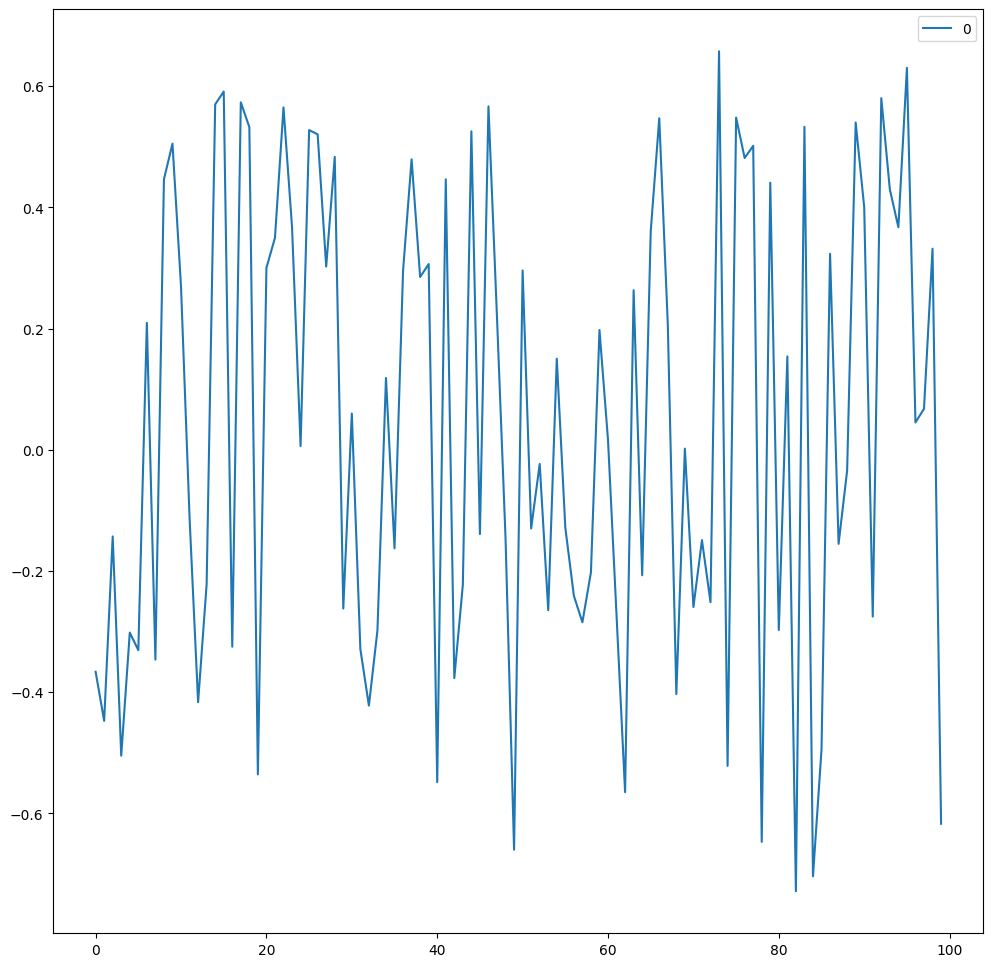

In [7]:
pd.DataFrame(series[:100, -1]).plot(figsize=(12, 12))

In [8]:
x_train, y_train = series[:7000, :n_steps], series[:7000, -1]
x_valid, y_valid = series[7000:9000, :n_steps], series[7000:9000, -1]
x_test, y_test = series[9000:, :n_steps], series[9000:, -1]

In [9]:
x_train.shape[1:]

(50, 1)

In [10]:
y_pred = x_valid[:, -1]
keras.losses.mean_squared_error(y_valid, y_pred), np.mean(keras.losses.mean_squared_error(y_valid, y_pred))

(<tf.Tensor: shape=(2000,), dtype=float32, numpy=
 array([6.2880437e-03, 6.4281583e-02, 1.9897085e-03, ..., 4.8250750e-02,
        4.0459065e-03, 3.2367716e-05], dtype=float32)>,
 0.021099424)

## Métricas Baseline
### Flatten e Dense

In [11]:
model = Sequential()
model.add(Flatten(input_shape=x_train.shape[1:]))
model.add(Dense(1))

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 50)                0         
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 51 (204.00 Byte)
Trainable params: 51 (204.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [13]:
model.compile(loss=keras.losses.mean_squared_error, metrics=[keras.metrics.R2Score()], optimizer="adam")

In [14]:
history = model.fit(x_train, y_train, epochs=20, validation_data=(x_valid, y_valid))

Epoch 1/20

219/219 [==============================] - 2s 4ms/step - loss: 0.1045 - r2_score: 0.2755 - val_loss: 0.0302 - val_r2_score: 0.7906
Epoch 2/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0230 - r2_score: 0.8404 - val_loss: 0.0185 - val_r2_score: 0.8717
Epoch 3/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0157 - r2_score: 0.8915 - val_loss: 0.0141 - val_r2_score: 0.9022
Epoch 4/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0125 - r2_score: 0.9136 - val_loss: 0.0118 - val_r2_score: 0.9180
Epoch 5/20
219/219 [==============================] - 1s 2ms/step - loss: 0.0106 - r2_score: 0.9263 - val_loss: 0.0103 - val_r2_score: 0.9288
Epoch 6/20
219/219 [==============================] - 1s 2ms/step - loss: 0.0093 - r2_score: 0.9354 - val_loss: 0.0090 - val_r2_score: 0.9374
Epoch 7/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0083 - r2_score: 0.9426 - val_loss: 0.0080 - val_r2_score: 0.9443
Epoch

<Axes: >

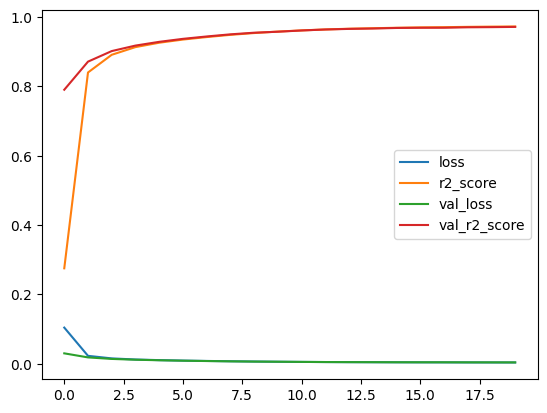

In [15]:
pd.DataFrame(history.history).plot()

## Implementando um RNN simples

In [16]:
model = Sequential()
model.add(SimpleRNN(1, input_shape=[None, 1]))

In [17]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 1)                 3         
                                                                 
Total params: 3 (12.00 Byte)
Trainable params: 3 (12.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [18]:
model.compile(loss=keras.losses.mean_squared_error, metrics=[keras.metrics.R2Score()], optimizer="adam")

In [19]:
history = model.fit(x_train, y_train, epochs=20, validation_data=(x_valid, y_valid))

Epoch 1/20


219/219 [==============================] - 5s 10ms/step - loss: 0.2995 - r2_score: -1.0764 - val_loss: 0.2424 - val_r2_score: -0.6797
Epoch 2/20
219/219 [==============================] - 2s 7ms/step - loss: 0.1816 - r2_score: -0.2592 - val_loss: 0.1289 - val_r2_score: 0.1066
Epoch 3/20
219/219 [==============================] - 2s 7ms/step - loss: 0.0890 - r2_score: 0.3832 - val_loss: 0.0609 - val_r2_score: 0.5778
Epoch 4/20
219/219 [==============================] - 2s 10ms/step - loss: 0.0467 - r2_score: 0.6759 - val_loss: 0.0384 - val_r2_score: 0.7340
Epoch 5/20
219/219 [==============================] - 2s 9ms/step - loss: 0.0348 - r2_score: 0.7589 - val_loss: 0.0323 - val_r2_score: 0.7758
Epoch 6/20
219/219 [==============================] - 2s 8ms/step - loss: 0.0310 - r2_score: 0.7849 - val_loss: 0.0296 - val_r2_score: 0.7945
Epoch 7/20
219/219 [==============================] - 2s 7ms/step - loss: 0.0287 - r2_score: 0.8009 - val_loss: 0.0276 - val_r2_score: 0.8090
Epoch 8/20
2

<Axes: >

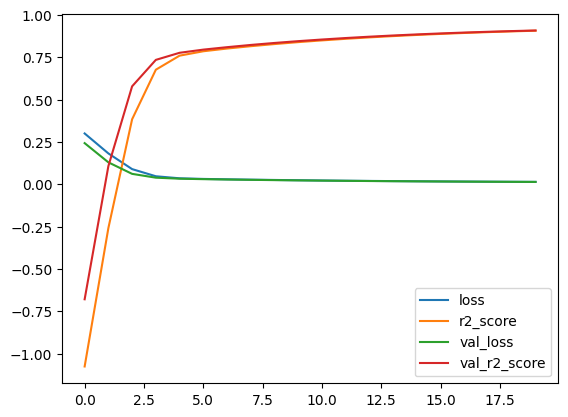

In [20]:
pd.DataFrame(history.history).plot()

## RNNs Profundas

In [21]:
model = Sequential()
model.add(SimpleRNN(20, return_sequences=True, input_shape=[None, 1]))
model.add(SimpleRNN(20, return_sequences=True))
model.add(SimpleRNN(1))

In [22]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_1 (SimpleRNN)    (None, None, 20)          440       
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, None, 20)          820       
                                                                 
 simple_rnn_3 (SimpleRNN)    (None, 1)                 22        
                                                                 
Total params: 1282 (5.01 KB)
Trainable params: 1282 (5.01 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [23]:
model.compile(loss=keras.losses.mean_squared_error, metrics=[keras.metrics.R2Score()], optimizer="adam")

In [24]:
history = model.fit(x_train, y_train, epochs=20, validation_data=(x_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 12s 28ms/step - loss: 0.0179 - r2_score: 0.8760 - val_loss: 0.0051 - val_r2_score: 0.9648
Epoch 2/20
219/219 [==============================] - 5s 25ms/step - loss: 0.0040 - r2_score: 0.9722 - val_loss: 0.0037 - val_r2_score: 0.9744
Epoch 3/20
219/219 [==============================] - 5s 24ms/step - loss: 0.0033 - r2_score: 0.9770 - val_loss: 0.0033 - val_r2_score: 0.9773
Epoch 4/20
219/219 [==============================] - 5s 24ms/step - loss: 0.0031 - r2_score: 0.9785 - val_loss: 0.0031 - val_r2_score: 0.9783
Epoch 5/20
219/219 [==============================] - 5s 24ms/step - loss: 0.0030 - r2_score: 0.9791 - val_loss: 0.0032 - val_r2_score: 0.9778
Epoch 6/20
219/219 [==============================] - 5s 22ms/step - loss: 0.0030 - r2_score: 0.9795 - val_loss: 0.0032 - val_r2_score: 0.9779
Epoch 7/20
219/219 [==============================] - 6s 26ms/step - loss: 0.0029 - r2_score: 0.9799 - val_loss: 0.0032 - val_r2_score: 0.978

<Axes: >

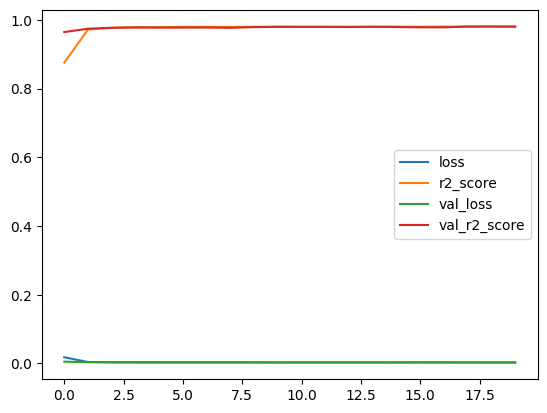

In [25]:
pd.DataFrame(history.history).plot()

In [26]:
model.evaluate(x_test, y_test)

32/32 [==============================] - 0s 11ms/step - loss: 0.0027 - r2_score: 0.9812


[0.0026994028594344854, 0.9811778664588928]

In [27]:
new_df = pd.concat([pd.DataFrame(series[1], columns=[0]), pd.DataFrame(series[-1], columns=[1])], axis=1)

In [28]:
new_df.head()

,0,1
0,-0.383867,0.407741
1,-0.382194,0.264537
2,-0.348875,0.108827
3,-0.334766,-0.162678
4,-0.130204,-0.345191


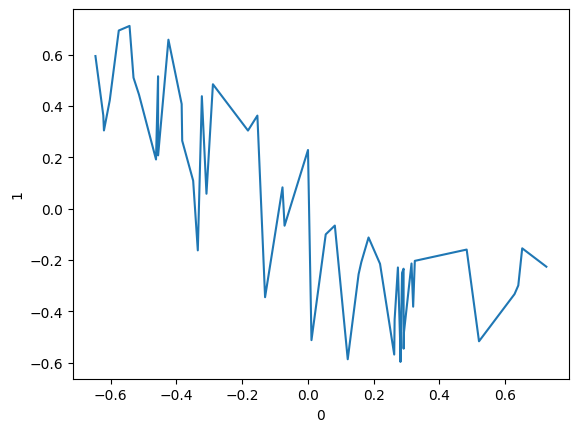

In [29]:
sns.lineplot(data=new_df, x=0, y=1);

In [30]:
series = generate_time_series(1, n_steps + 10)
x_new, y_new = series[:, :n_steps], series[:, n_steps:]
x = x_new

In [31]:
for step_ahead in range(10):
    y_pred_one = model.predict(x[:, step_ahead:])[:, np.newaxis, :]
    x = np.concatenate([x, y_pred_one], axis=1)

y_pred = x[:, n_steps:]

1/1 [==============================] - 0s 32ms/step


<Axes: >

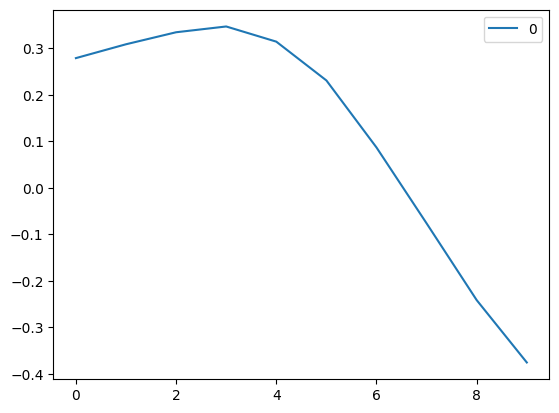

In [32]:
pd.DataFrame(y_pred[0]).plot()

In [33]:
n_steps = 50
series = generate_time_series(10000, n_steps + 10)

In [34]:
x_train, y_train = series[:7000, :n_steps], series[:7000, -10:, 0]
x_valid, y_valid = series[7000:9000, :n_steps], series[7000:9000, -10:, 0]
x_test, y_test = series[9000:, :n_steps], series[9000:, -10:, 0]

In [35]:
model = Sequential()
model.add(SimpleRNN(20, return_sequences=True, input_shape=[None, 1]))
model.add(SimpleRNN(20))
model.add(Dense(10))

In [36]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_4 (SimpleRNN)    (None, None, 20)          440       
                                                                 
 simple_rnn_5 (SimpleRNN)    (None, 20)                820       
                                                                 
 dense_1 (Dense)             (None, 10)                210       
                                                                 
Total params: 1470 (5.74 KB)
Trainable params: 1470 (5.74 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [37]:
model.compile(loss=keras.losses.mean_squared_error, metrics=[keras.metrics.R2Score()], optimizer="adam")

In [38]:
history = model.fit(x_train, y_train, epochs=20, validation_data=(x_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 8s 22ms/step - loss: 0.0688 - r2_score: 0.5260 - val_loss: 0.0307 - val_r2_score: 0.7836
Epoch 2/20
219/219 [==============================] - 4s 17ms/step - loss: 0.0230 - r2_score: 0.8415 - val_loss: 0.0198 - val_r2_score: 0.8606
Epoch 3/20
219/219 [==============================] - 4s 18ms/step - loss: 0.0175 - r2_score: 0.8793 - val_loss: 0.0151 - val_r2_score: 0.8932
Epoch 4/20
219/219 [==============================] - 4s 18ms/step - loss: 0.0145 - r2_score: 0.8997 - val_loss: 0.0162 - val_r2_score: 0.8853
Epoch 5/20
219/219 [==============================] - 3s 15ms/step - loss: 0.0137 - r2_score: 0.9051 - val_loss: 0.0129 - val_r2_score: 0.9092
Epoch 6/20
219/219 [==============================] - 4s 19ms/step - loss: 0.0132 - r2_score: 0.9086 - val_loss: 0.0129 - val_r2_score: 0.9087
Epoch 7/20
219/219 [==============================] - 4s 18ms/step - loss: 0.0127 - r2_score: 0.9126 - val_loss: 0.0136 - val_r2_score: 0.9037

<Axes: >

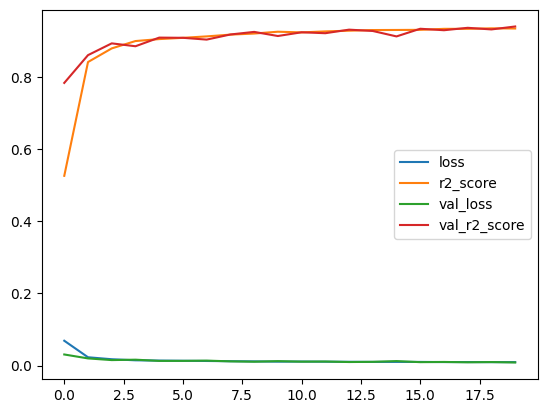

In [39]:
pd.DataFrame(history.history).plot()

In [40]:
model.evaluate(x_test, y_test)

32/32 [==============================] - 0s 5ms/step - loss: 0.0082 - r2_score: 0.9431


[0.008218502625823021, 0.943149745464325]

In [41]:
model = Sequential()
model.add(SimpleRNN(20, return_sequences=True, input_shape=[None, 1]))
model.add(SimpleRNN(20))

In [42]:
x = np.array([c for c in range(10000)])
y = np.array([np.random.randint(0, 10) for c in range(10000)])

In [43]:
x.shape, y.shape

((10000,), (10000,))

In [44]:
df = pd.concat([pd.DataFrame(x, columns=["x"]), pd.DataFrame(y, columns=["y"])], axis=1)

<Axes: >

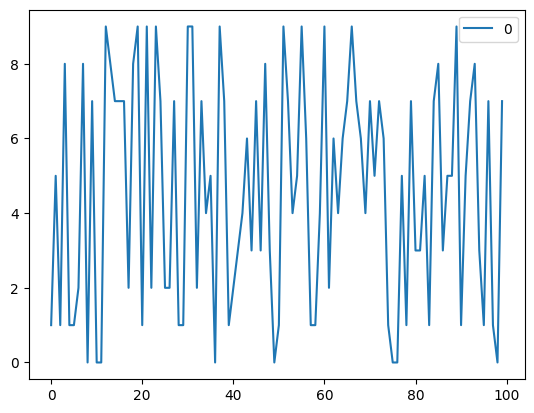

In [45]:
pd.DataFrame(y).iloc[:100, :].plot()

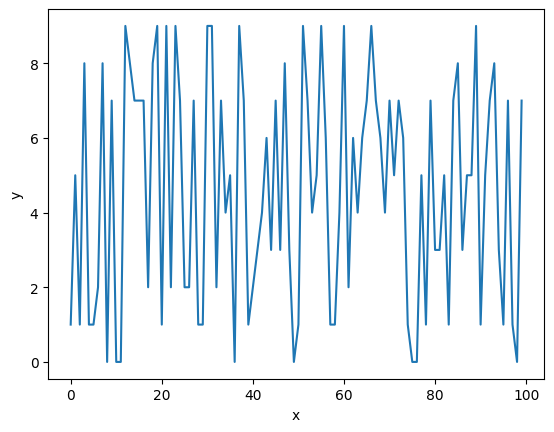

In [46]:
sns.lineplot(data=df.iloc[:100, :], x="x", y="y");

In [67]:
y = pd.get_dummies(df["y"]).astype(np.float32)
y

,0,1,2,3,4,5,6,7,8,9
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
9995,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9996,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9997,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


### Flatten

In [68]:
x = np.expand_dims(df["x"].values, axis=1).astype(np.float32)
#y = np.expand_dims(y, axis=1).astype(np.float32)

In [69]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

In [70]:
x_train.shape, y_train.shape

((8000, 1), (8000, 10))

In [71]:
model = Sequential()
model.add(SimpleRNN(20, input_shape=[None, 1], return_sequences=True))
model.add(SimpleRNN(20))
model.add(Dense(10, activation="softmax"))

In [72]:
model.compile(loss=keras.losses.mean_squared_error, metrics=[keras.metrics.R2Score()], optimizer="adam")

In [73]:
history = model.fit(x_train, y_train, epochs=20, validation_data=(x_test, y_test))

Epoch 1/20
250/250 [==============================] - 5s 5ms/step - loss: 0.0901 - r2_score: -0.0016 - val_loss: 0.0900 - val_r2_score: -2.4916e-04
Epoch 2/20
250/250 [==============================] - 1s 3ms/step - loss: 0.0901 - r2_score: -8.9319e-04 - val_loss: 0.0901 - val_r2_score: -0.0012
Epoch 3/20
250/250 [==============================] - 1s 3ms/step - loss: 0.0901 - r2_score: -0.0010 - val_loss: 0.0901 - val_r2_score: -0.0011
Epoch 4/20
250/250 [==============================] - 1s 4ms/step - loss: 0.0901 - r2_score: -9.9978e-04 - val_loss: 0.0900 - val_r2_score: -2.8303e-04
Epoch 5/20
250/250 [==============================] - 1s 4ms/step - loss: 0.0901 - r2_score: -9.1126e-04 - val_loss: 0.0900 - val_r2_score: -9.0711e-04
Epoch 6/20
250/250 [==============================] - 1s 4ms/step - loss: 0.0901 - r2_score: -9.6321e-04 - val_loss: 0.0900 - val_r2_score: -4.8403e-04
Epoch 7/20
250/250 [==============================] - 1s 4ms/step - loss: 0.0900 - r2_score: -6.4813e-04

## LSTM

In [117]:
n_steps = 50
series = generate_time_series(10000, n_steps + 10)
x_train, y_train = series[:7000, :n_steps], series[:7000, -10:, 0]
x_valid, y_valid = series[7000:9000, :n_steps], series[7000:9000, -10:, 0]
x_test, y_test = series[9000:, :n_steps], series[9000:, -10:, 0]

In [118]:
model = Sequential()
model.add(GRU(20, input_shape=[None, 1], return_sequences=True))
model.add(GRU(20))
model.add(Dense(10))

In [119]:
model.summary()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_10 (GRU)                (None, None, 20)          1380      
                                                                 
 gru_11 (GRU)                (None, 20)                2520      
                                                                 
 dense_14 (Dense)            (None, 10)                210       
                                                                 
Total params: 4110 (16.05 KB)
Trainable params: 4110 (16.05 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [120]:
model.compile(loss=keras.losses.mean_squared_error, metrics=[keras.metrics.R2Score()], optimizer="adam")

In [121]:
history = model.fit(x_train, y_train, epochs=20, validation_data=(x_valid, y_valid))

Epoch 1/20


219/219 [==============================] - 17s 39ms/step - loss: 0.0652 - r2_score: 0.5460 - val_loss: 0.0430 - val_r2_score: 0.6970
Epoch 2/20
219/219 [==============================] - 7s 30ms/step - loss: 0.0382 - r2_score: 0.7325 - val_loss: 0.0348 - val_r2_score: 0.7546
Epoch 3/20
219/219 [==============================] - 7s 30ms/step - loss: 0.0317 - r2_score: 0.7781 - val_loss: 0.0288 - val_r2_score: 0.7968
Epoch 4/20
219/219 [==============================] - 7s 34ms/step - loss: 0.0247 - r2_score: 0.8269 - val_loss: 0.0216 - val_r2_score: 0.8479
Epoch 5/20
219/219 [==============================] - 7s 33ms/step - loss: 0.0176 - r2_score: 0.8768 - val_loss: 0.0153 - val_r2_score: 0.8924
Epoch 6/20
219/219 [==============================] - 7s 32ms/step - loss: 0.0142 - r2_score: 0.9005 - val_loss: 0.0149 - val_r2_score: 0.8951
Epoch 7/20
219/219 [==============================] - 7s 32ms/step - loss: 0.0128 - r2_score: 0.9104 - val_loss: 0.0125 - val_r2_score: 0.9121
Epoch 8/2

### Usando Camadas Convolucionais 1D para processar sequências

In [128]:
model = Sequential()
model.add(Conv1D(filters=20, kernel_size=4, strides=2, padding="VALID", input_shape=x_train.shape[1:]))
model.add(GRU(20, return_sequences=True))
model.add(GRU(20, return_sequences=True))
model.add(TimeDistributed(Dense(10)))

In [129]:
model.compile(loss="mse", optimizer="adam", metrics=[keras.metrics.R2Score()])

In [131]:
#history = model.fit(x_train, y_train[:, 3::2], epochs=20, validation_data=(x_valid, y_valid[:, 3::2]))

### Wavenet

In [174]:
model = Sequential()
model.add(InputLayer(input_shape=x_train.shape[1:]))

for rate in (1, 2, 4, 8) * 2:
    model.add(Conv1D(filters=20, kernel_size=2, padding="VALID", activation="relu", dilation_rate=rate))

model.add(Conv1D(filters=20, kernel_size=2))
model.add(Flatten())
model.add(Dense(units=10, activation='linear'))  # Adjust 'units' based on your task


In [175]:
model.compile(optimizer="adam", metrics=[keras.metrics.R2Score()], loss="mse")

In [176]:
x_train.shape, y_train.shape

((7000, 50, 1), (7000, 10))

In [177]:
x_valid.shape, y_valid.shape

((2000, 50, 1), (2000, 10))

In [178]:
history = model.fit(x_train, y_train, epochs=20, validation_data=(x_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 5s 9ms/step - loss: 0.0554 - r2_score: 0.6135 - val_loss: 0.0220 - val_r2_score: 0.8453
Epoch 2/20
219/219 [==============================] - 2s 7ms/step - loss: 0.0183 - r2_score: 0.8722 - val_loss: 0.0143 - val_r2_score: 0.8993
Epoch 3/20
219/219 [==============================] - 2s 7ms/step - loss: 0.0129 - r2_score: 0.9100 - val_loss: 0.0113 - val_r2_score: 0.9209
Epoch 4/20
219/219 [==============================] - 2s 7ms/step - loss: 0.0106 - r2_score: 0.9255 - val_loss: 0.0104 - val_r2_score: 0.9265
Epoch 5/20
219/219 [==============================] - 1s 7ms/step - loss: 0.0095 - r2_score: 0.9335 - val_loss: 0.0089 - val_r2_score: 0.9374
Epoch 6/20
219/219 [==============================] - 1s 7ms/step - loss: 0.0086 - r2_score: 0.9396 - val_loss: 0.0100 - val_r2_score: 0.9295
Epoch 7/20
219/219 [==============================] - 1s 7ms/step - loss: 0.0083 - r2_score: 0.9417 - val_loss: 0.0081 - val_r2_score: 0.9429
Epoch 

## Exercícios

In [179]:
import tensorflow_datasets as tfds

In [11]:
df = pd.read_csv("data/jsb_chorales/jsb_chorales/train/chorale_001.csv")
df

,note0,note1,note2,note3
0,69,64,61,57
1,69,64,61,57
2,69,64,61,57
3,69,64,61,57
4,71,64,59,56
...,...,...,...,...
223,69,61,52,45
224,69,61,52,45
225,69,61,52,45
226,69,61,52,45


In [21]:
files_train = os.listdir("data/jsb_chorales/jsb_chorales/train")
files_test = os.listdir("data/jsb_chorales/jsb_chorales/test")
files_valid = os.listdir("data/jsb_chorales/jsb_chorales/valid")

In [30]:
df_train = pd.concat([pd.read_csv("data/jsb_chorales/jsb_chorales/train/"+c) for c in files_train])
df_train.head()

,note0,note1,note2,note3
0,74,70,65,58
1,74,70,65,58
2,74,70,65,58
3,74,70,65,58
4,75,70,58,55


In [29]:
df_train.shape

(55228, 4)

In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 228 entries, 0 to 227
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   note0   228 non-null    int64
 1   note1   228 non-null    int64
 2   note2   228 non-null    int64
 3   note3   228 non-null    int64
dtypes: int64(4)
memory usage: 7.3 KB


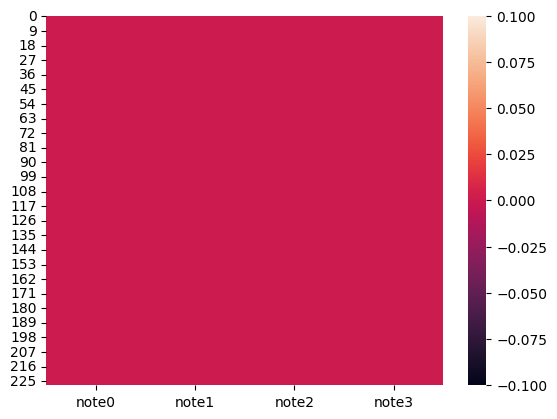

In [31]:
sns.heatmap(df.isnull());

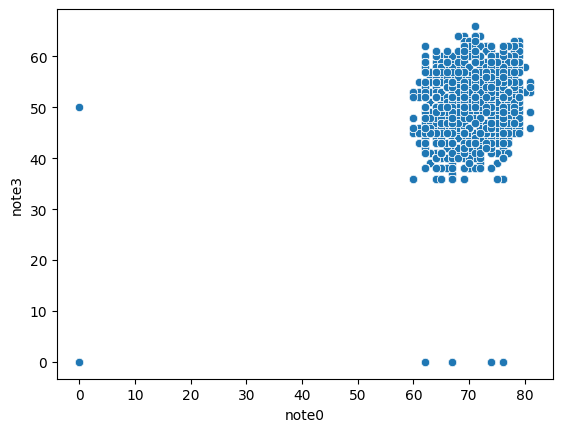

In [36]:
sns.scatterplot(data=df_train, x="note0", y="note3");

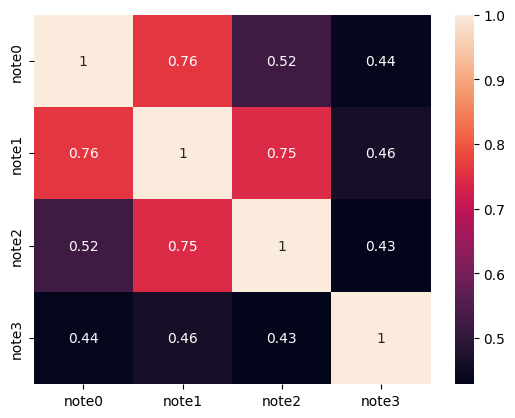

In [38]:
sns.heatmap(df_train.corr(), annot=True);

In [40]:
df_train.shape

(55228, 4)

In [74]:
y_train = np.array([c for c in range(df_train.shape[0])])
x_train = np.array(df_train.values)

In [67]:
x_train, y_train = np.expand_dims(x_train, axis=1).astype(np.float32), np.expand_dims(y_train, axis=1).astype(np.float32)

In [75]:
x_train

array([[74, 70, 65, 58],
       [74, 70, 65, 58],
       [74, 70, 65, 58],
       ...,
       [69, 64, 61, 45],
       [69, 64, 61, 45],
       [69, 64, 61, 45]], dtype=int64)

In [76]:
x_train.shape, y_train.shape

((55228, 4), (55228,))

In [84]:
DOWNLOAD_ROOT = "https://github.com/ageron/handson-ml2/raw/master/datasets/jsb_chorales/"
FILENAME = "jsb_chorales.tgz"
filepath = keras.utils.get_file(FILENAME,
                                DOWNLOAD_ROOT + FILENAME,
                                cache_subdir="datasets/jsb_chorales",
                                extract=True)

117661/117661 [==============================] - 0s 0us/step


In [85]:
from pathlib import Path

In [86]:
jsb_chorales_dir = Path(filepath).parent
train_files = sorted(jsb_chorales_dir.glob("train/chorale_*.csv"))
valid_files = sorted(jsb_chorales_dir.glob("valid/chorale_*.csv"))
test_files = sorted(jsb_chorales_dir.glob("test/chorale_*.csv"))

In [87]:
import pandas as pd

def load_chorales(filepaths):
    return [pd.read_csv(filepath).values.tolist() for filepath in filepaths]

train_chorales = load_chorales(train_files)
valid_chorales = load_chorales(valid_files)
test_chorales = load_chorales(test_files)

In [88]:
notes = set()
for chorales in (train_chorales, valid_chorales, test_chorales):
    for chorale in chorales:
        for chord in chorale:
            notes |= set(chord)

n_notes = len(notes)
min_note = min(notes - {0})
max_note = max(notes)

assert min_note == 36
assert max_note == 81

In [89]:
n_embedding_dims = 5
model = keras.models.Sequential([
    keras.layers.Embedding(input_dim=n_notes, output_dim=n_embedding_dims,
                           input_shape=[None]),
    keras.layers.Conv1D(32, kernel_size=2, padding="causal", activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv1D(48, kernel_size=2, padding="causal", activation="relu", dilation_rate=2),
    keras.layers.BatchNormalization(),
    keras.layers.Conv1D(64, kernel_size=2, padding="causal", activation="relu", dilation_rate=4),
    keras.layers.BatchNormalization(),
    keras.layers.Conv1D(96, kernel_size=2, padding="causal", activation="relu", dilation_rate=8),
    keras.layers.BatchNormalization(),
    keras.layers.LSTM(256, return_sequences=True),
    keras.layers.Dense(n_notes, activation="softmax")
])


In [92]:
def create_target(batch):
    X = batch[:, :-1]
    Y = batch[:, 1:] # predict next note in each arpegio, at each step
    return X, Y

def preprocess(window):
    window = tf.where(window == 0, window, window - min_note + 1) # shift values
    return tf.reshape(window, [-1]) # convert to arpegio

def bach_dataset(chorales, batch_size=32, shuffle_buffer_size=None,
                 window_size=32, window_shift=16, cache=True):
    def batch_window(window):
        return window.batch(window_size + 1)

    def to_windows(chorale):
        dataset = tf.data.Dataset.from_tensor_slices(chorale)
        dataset = dataset.window(window_size + 1, window_shift, drop_remainder=True)
        return dataset.flat_map(batch_window)

    chorales = tf.ragged.constant(chorales, ragged_rank=1)
    dataset = tf.data.Dataset.from_tensor_slices(chorales)
    dataset = dataset.flat_map(to_windows).map(preprocess)
    if cache:
        dataset = dataset.cache()
    if shuffle_buffer_size:
        dataset = dataset.shuffle(shuffle_buffer_size)
    dataset = dataset.batch(batch_size)
    dataset = dataset.map(create_target)
    return dataset.prefetch(1)

In [93]:
train_set = bach_dataset(train_chorales, shuffle_buffer_size=1000)
valid_set = bach_dataset(valid_chorales)
test_set = bach_dataset(test_chorales)

In [106]:
for c in train_set:
    print(c[0])

tf.Tensor(
[[39 31 26 ... 39 31 26]
 [37 34 29 ... 36 32 27]
 [36 31 28 ... 36 33 29]
 ...
 [35 35 30 ... 36 32 27]
 [37 32 28 ... 43 34 28]
 [39 32 24 ... 32 29 24]], shape=(32, 131), dtype=int32)
tf.Tensor(
[[32 29 24 ... 32 27 24]
 [41 32 20 ... 42 37 25]
 [32 27 20 ... 37 30 22]
 ...
 [37 34 30 ... 37 30 22]
 [39 34 27 ... 32 27 23]
 [34 29 25 ... 37 29 24]], shape=(32, 131), dtype=int32)
tf.Tensor(
[[35 30 27 ... 35 27 23]
 [33 29 24 ... 33 29 24]
 [41 33 24 ... 37 29 22]
 ...
 [37 34 29 ... 37 32 25]
 [39 32 23 ... 39 30 23]
 [40 35 32 ... 40 32 20]], shape=(32, 131), dtype=int32)
tf.Tensor(
[[40 32 25 ... 32 28 23]
 [32 27 20 ... 32 28 25]
 [36 30 27 ... 34 26 17]
 ...
 [35 30 27 ... 30 25 22]
 [37 30 30 ... 35 30 27]
 [42 25 22 ... 38 29 22]], shape=(32, 131), dtype=int32)
tf.Tensor(
[[30 25 22 ... 42 30 27]
 [36 31 28 ... 36 29 21]
 [31 29 24 ... 40 34 26]
 ...
 [40 36 31 ... 33 29 26]
 [38 34 29 ... 41 29 24]
 [37 31 22 ... 39 32 27]], shape=(32, 131), dtype=int32)
tf.Tensor(

In [94]:
optimizer = keras.optimizers.Nadam(learning_rate=1e-3)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
model.fit(train_set, epochs=20, validation_data=valid_set)

Epoch 1/20

98/98 [==============================] - 25s 163ms/step - loss: 1.9264 - accuracy: 0.5133 - val_loss: 3.5455 - val_accuracy: 0.0330
Epoch 2/20
98/98 [==============================] - 13s 138ms/step - loss: 0.8930 - accuracy: 0.7637 - val_loss: 3.9343 - val_accuracy: 0.0093
Epoch 3/20
98/98 [==============================] - 15s 150ms/step - loss: 0.7412 - accuracy: 0.7940 - val_loss: 3.5723 - val_accuracy: 0.0297
Epoch 4/20
98/98 [==============================] - 16s 167ms/step - loss: 0.6662 - accuracy: 0.8093 - val_loss: 2.9326 - val_accuracy: 0.1683
Epoch 5/20
98/98 [==============================] - 16s 165ms/step - loss: 0.6129 - accuracy: 0.8211 - val_loss: 1.9777 - val_accuracy: 0.4031
Epoch 6/20
98/98 [==============================] - 15s 151ms/step - loss: 0.5708 - accuracy: 0.8310 - val_loss: 1.0222 - val_accuracy: 0.6949
Epoch 7/20
98/98 [==============================] - 15s 149ms/step - loss: 0.5331 - accuracy: 0.8397 - val_loss: 0.6752 - val_accuracy: 0.804

In [95]:
model.evaluate(test_set)

34/34 [==============================] - 2s 52ms/step - loss: 0.6634 - accuracy: 0.8165


[0.6633724570274353, 0.8164719343185425]

In [96]:
def generate_chorale(model, seed_chords, length):
    arpegio = preprocess(tf.constant(seed_chords, dtype=tf.int64))
    arpegio = tf.reshape(arpegio, [1, -1])
    for chord in range(length):
        for note in range(4):
            #next_note = model.predict_classes(arpegio)[:1, -1:]
            next_note = np.argmax(model.predict(arpegio), axis=-1)[:1, -1:]
            arpegio = tf.concat([arpegio, next_note], axis=1)
    arpegio = tf.where(arpegio == 0, arpegio, arpegio + min_note - 1)
    return tf.reshape(arpegio, shape=[-1, 4])

In [97]:
seed_chords = test_chorales[2][:8]
#play_chords(seed_chords, amplitude=0.2)

In [98]:
new_chorale = generate_chorale(model, seed_chords, 56)
#play_chords(new_chorale)#

1/1 [==============================] - 0s 49ms/step


In [99]:
new_chorale

<tf.Tensor: shape=(64, 4), dtype=int64, numpy=
array([[73, 68, 61, 53],
       [73, 68, 61, 53],
       [73, 68, 61, 53],
       [73, 68, 61, 53],
       [69, 66, 61, 54],
       [69, 66, 61, 54],
       [69, 66, 61, 54],
       [69, 66, 61, 54],
       [69, 66, 61, 54],
       [69, 66, 61, 54],
       [69, 66, 61, 54],
       [69, 66, 61, 54],
       [69, 66, 61, 54],
       [69, 66, 61, 54],
       [69, 66, 61, 54],
       [69, 66, 61, 54],
       [69, 66, 61, 54],
       [69, 66, 61, 54],
       [69, 66, 61, 54],
       [69, 66, 61, 54],
       [69, 66, 61, 54],
       [69, 66, 61, 54],
       [69, 66, 61, 54],
       [69, 66, 61, 54],
       [69, 66, 61, 54],
       [69, 66, 61, 54],
       [69, 66, 61, 54],
       [69, 66, 61, 54],
       [69, 66, 61, 54],
       [69, 66, 61, 54],
       [69, 66, 61, 54],
       [69, 66, 61, 54],
       [69, 66, 61, 54],
       [69, 66, 61, 54],
       [69, 66, 61, 54],
       [69, 66, 61, 54],
       [69, 66, 61, 54],
       [69, 66, 61, 54],
   

In [109]:
model.save_weights("models/weights/rnn_15_exe.h5")

In [111]:
keras.models.save_model(model, "models/rnn_15_exe.h5")

C:\Users\franc\AppData\Local\Temp\ipykernel_4440\3427872343.py:1: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  keras.models.save_model(model, "models/rnn_15_exe.h5")
